## ***Intel AI Model***

> Fater RCNN

> Distance Measurement

> Recommendation



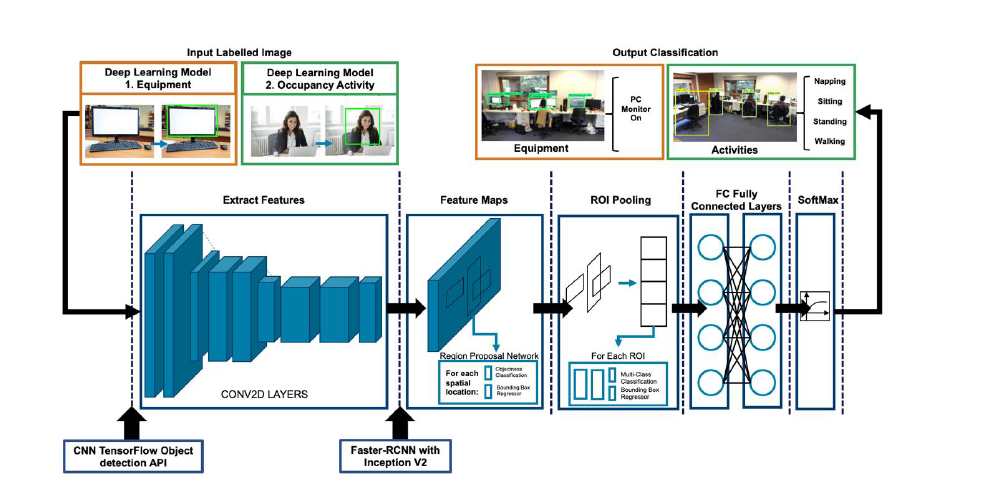


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'IntelAiHackathon'
assert FOLDERNAME is not None, "IntelAiHackathon"

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
print('file open sucessfully')

Mounted at /content/drive
file open sucessfully


In [4]:
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage import io, transform as sk_transform
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os
import pandas as pd

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import cv2

#**Loading Data**


In [5]:
import os
import pandas as pd
import torch
from skimage import io, transform as sk_transform
from torch.nn.utils.rnn import pad_sequence

from skimage import color
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.

    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx

        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()

    def __len__(self):
        return self.img_data_all.size(dim=0)

    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []

        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)

        for i, img_path in enumerate(img_paths):

            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue

            # read and resize image
            img = io.imread(img_path)
            # print("Image path:", img_path)
            # print("Image shape before resize:", img.shape)

            # Convert RGBA to RGB if necessary
            if img.shape[2] == 4:
                 img = color.rgba2rgb(img)

            img = sk_transform.resize(img, self.img_size)
            # print("Image shape after resize:", img.shape)

            # if img.shape[2] not in [3, 4]:
            #     raise ValueError("Input image must have 3 (RGB) or 4 (RGBA) channels.")

            # Ensure the image has 3 channels (RGB)
            if img.shape[2] != 3:
                 raise ValueError("Input image must have 3 (RGB) channels.")

            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)

            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])

            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)

        if len(img_data_all) == 0:
            raise RuntimeError("No valid images found.")

        # pad bounding boxes and classes so they are of the same size
        if len(gt_idxs_all) > 0:
            gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
            gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        else:
            gt_bboxes_pad = torch.zeros((0, 0, 4), dtype=torch.float32)
            gt_classes_pad = torch.zeros((0, 0), dtype=torch.float32)

        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)

        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad


In [6]:
# Sample code to create ObjectDetectionDataset instance
img_width = 640
img_height = 480
annotation_path = "/content/drive/MyDrive/IntelAiHackathon/dataset/annotations1.xml"
image_dir = "/content/drive/MyDrive/IntelAiHackathon/dataset/images"
# name2idx = {'pad': -1, 'AirConditioner': 0, 'ceiling fan': 1, 'Human': 2, 'ON_Laptop': 3, 'OFF_Laptop': 4, 'Light on': 5, 'Light off': 6}
name2idx = {'pad': -1, 'ON_Laptop': 0, 'OFF_Laptop': 1}
idx2name = {v:k for k, v in name2idx.items()}

# Create Dataset and Dataloaders

In [7]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

In [8]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

# Grab a batch for demonstration

In [9]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break

img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

# Display Images and Bounding Boxes

In [10]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

In [11]:
import matplotlib.pyplot as plt

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

# Convolutional Backbone

In [12]:
model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [13]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [14]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [15]:
# run the image through the backbone
out = backbone(img_data_all)

In [16]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [17]:
out_c, out_h, out_w

(2048, 15, 20)

# Check how much the image has been down-scaled

In [18]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

***Visualize feature maps***

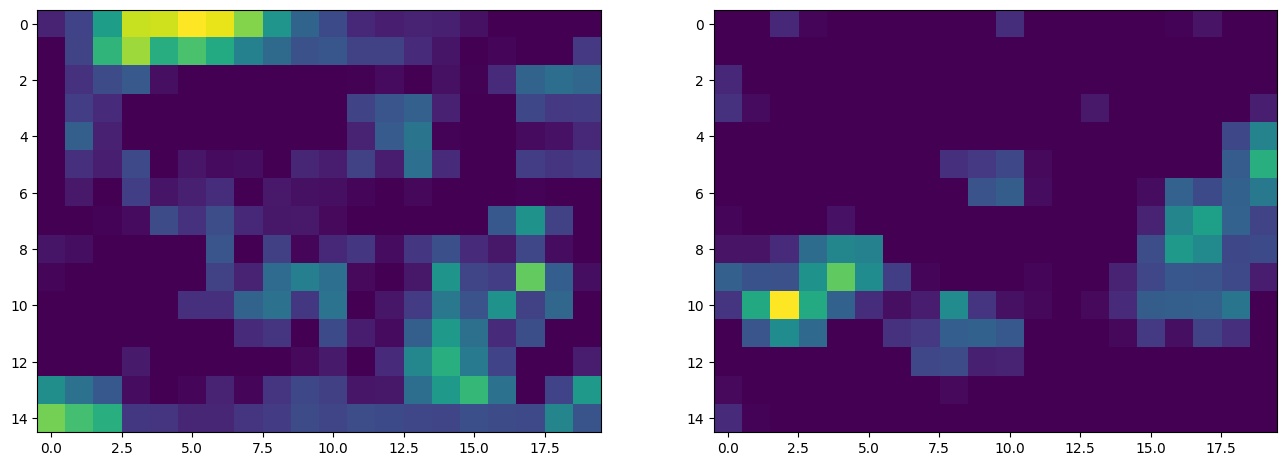

In [19]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

**Generate and Plot Anchors**

In [20]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

**Display Grid Mapping**

In [21]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

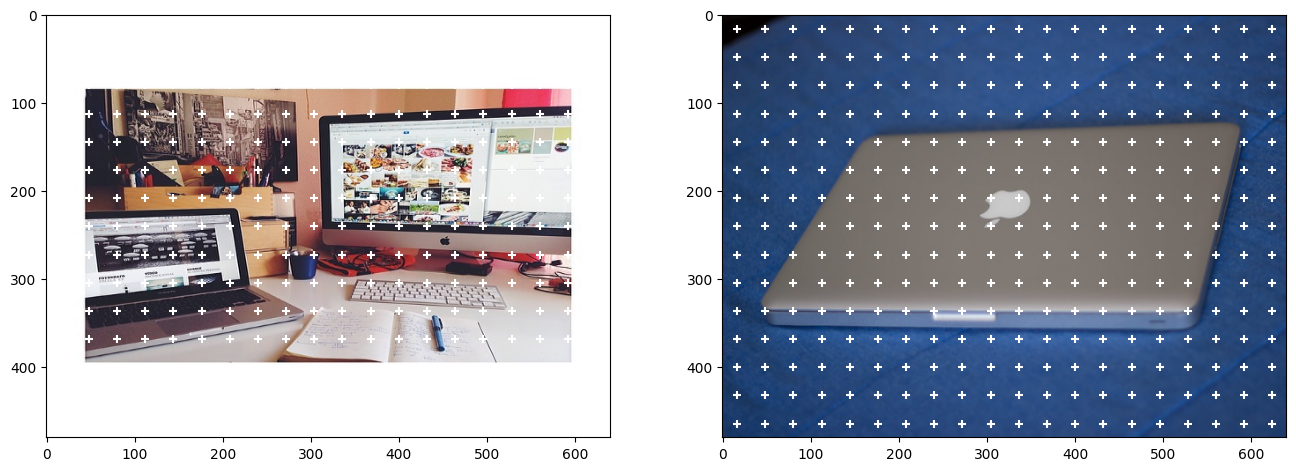

In [22]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

**Create Anchor Boxes around Anchor points**

In [23]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [24]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

**plot anchor boxes on a single anchor point**

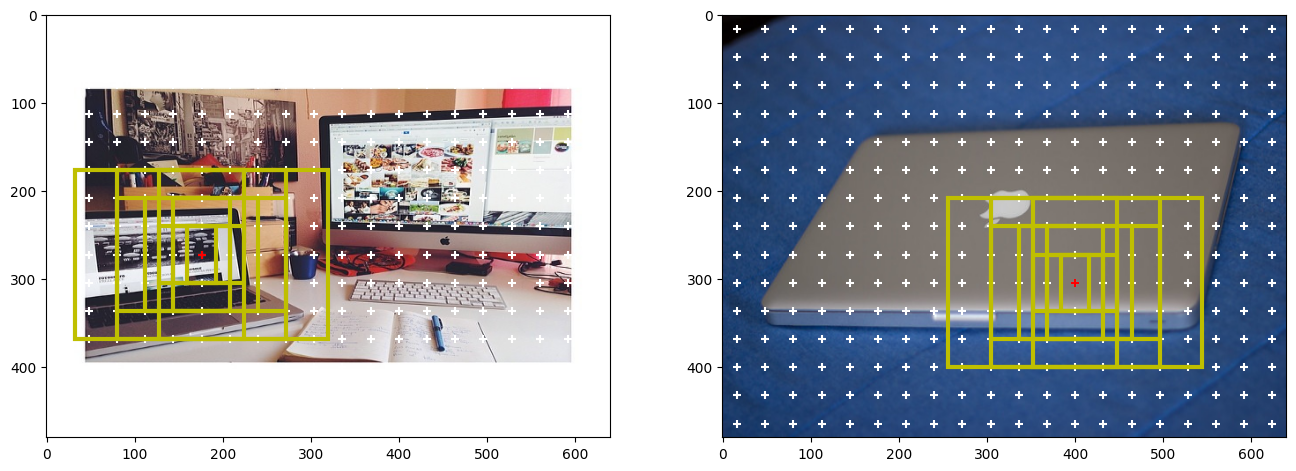

In [25]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

**plot all anchor boxes**

In [26]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

**Get Positive and Negative Anchors**

In [27]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [28]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

**Visualize positive anchor coordinates**

In [29]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

In [30]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

In [31]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)


**Building the model**

In [32]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

print("*****************")
print("Total loss:", total_loss)
print("proposals:", proposals_final)
print("confidence score:", conf_scores_final)
print("classes", classes_final)

---------------------
Loss1: tensor(14.5198, grad_fn=<DivBackward0>)
############################
loss 2: tensor(3.2906, grad_fn=<DivBackward0>)
Total rpn loss: tensor(30.9729, grad_fn=<AddBackward0>)
Classification loss: tensor(0.7582, grad_fn=<NllLossBackward0>)
Total loss: tensor(31.7311, grad_fn=<AddBackward0>)
*****************
Total loss: tensor(31.7311, grad_fn=<AddBackward0>)
proposals: [tensor([[ 6.2680, -0.2817, 12.9755,  4.6733],
        [ 6.6952, -0.0505, 15.8347,  4.7773],
        [ 6.4167, 12.4723, 12.3332, 14.9097],
        ...,
        [14.6579,  9.0221, 20.6026, 13.0117],
        [ 2.5185,  5.9720,  7.4159,  9.0772],
        [ 4.0474,  6.6254,  7.2874,  8.7026]]), tensor([[11.8727,  2.0839, 16.7079,  7.3640],
        [13.7716,  2.8361, 15.5732,  6.3564],
        [ 9.9482, -0.1999, 10.8629,  1.1919],
        ...,
        [ 9.5956, 12.0610, 12.9641, 14.8142],
        [14.5058, -0.3982, 17.2414,  3.7931],
        [ 6.4933,  0.7087, 10.9231,  3.1662]])]
confidence score: [

**Training Loop**

In [33]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    loss_list = []

    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:

            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss)

    return loss_list

In [34]:
learning_rate = 1e-3
n_epochs = 200

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)
print("$$$$$$$$$$$$$$$$$$$$4")
print(loss_list)

  0%|          | 0/200 [00:00<?, ?it/s]

---------------------
Loss1: tensor(15.0015, grad_fn=<DivBackward0>)
############################
loss 2: tensor(4.3609, grad_fn=<DivBackward0>)
Total rpn loss: tensor(36.8058, grad_fn=<AddBackward0>)
Classification loss: tensor(0.7319, grad_fn=<NllLossBackward0>)
Total loss: tensor(37.5377, grad_fn=<AddBackward0>)


  0%|          | 1/200 [00:09<30:55,  9.32s/it]

---------------------
Loss1: tensor(19.1332, grad_fn=<DivBackward0>)
############################
loss 2: tensor(216.5553, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1101.9094, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7126, grad_fn=<NllLossBackward0>)
Total loss: tensor(1103.6221, grad_fn=<AddBackward0>)


  1%|          | 2/200 [00:18<30:42,  9.31s/it]

---------------------
Loss1: tensor(25.1138, grad_fn=<DivBackward0>)
############################
loss 2: tensor(16.4100, grad_fn=<DivBackward0>)
Total rpn loss: tensor(107.1636, grad_fn=<AddBackward0>)
Classification loss: tensor(3.6477, grad_fn=<NllLossBackward0>)
Total loss: tensor(110.8112, grad_fn=<AddBackward0>)


  2%|▏         | 3/200 [00:26<27:54,  8.50s/it]

---------------------
Loss1: tensor(19.7697, grad_fn=<DivBackward0>)
############################
loss 2: tensor(3.1399, grad_fn=<DivBackward0>)
Total rpn loss: tensor(35.4690, grad_fn=<AddBackward0>)
Classification loss: tensor(2.5940, grad_fn=<NllLossBackward0>)
Total loss: tensor(38.0630, grad_fn=<AddBackward0>)


  2%|▏         | 4/200 [00:34<27:26,  8.40s/it]

---------------------
Loss1: tensor(19.9762, grad_fn=<DivBackward0>)
############################
loss 2: tensor(2.3847, grad_fn=<DivBackward0>)
Total rpn loss: tensor(31.8995, grad_fn=<AddBackward0>)
Classification loss: tensor(0.9356, grad_fn=<NllLossBackward0>)
Total loss: tensor(32.8351, grad_fn=<AddBackward0>)


  2%|▎         | 5/200 [00:43<27:37,  8.50s/it]

---------------------
Loss1: tensor(13.7824, grad_fn=<DivBackward0>)
############################
loss 2: tensor(2.1835, grad_fn=<DivBackward0>)
Total rpn loss: tensor(24.7001, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5067, grad_fn=<NllLossBackward0>)
Total loss: tensor(25.2069, grad_fn=<AddBackward0>)


  3%|▎         | 6/200 [00:50<26:12,  8.11s/it]

---------------------
Loss1: tensor(12.2067, grad_fn=<DivBackward0>)
############################
loss 2: tensor(2.0419, grad_fn=<DivBackward0>)
Total rpn loss: tensor(22.4164, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5192, grad_fn=<NllLossBackward0>)
Total loss: tensor(22.9356, grad_fn=<AddBackward0>)


  4%|▎         | 7/200 [00:59<26:41,  8.30s/it]

---------------------
Loss1: tensor(14.1384, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.9383, grad_fn=<DivBackward0>)
Total rpn loss: tensor(23.8301, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5229, grad_fn=<NllLossBackward0>)
Total loss: tensor(24.3530, grad_fn=<AddBackward0>)


  4%|▍         | 8/200 [01:06<25:56,  8.11s/it]

---------------------
Loss1: tensor(18.4746, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.6950, grad_fn=<DivBackward0>)
Total rpn loss: tensor(26.9496, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5272, grad_fn=<NllLossBackward0>)
Total loss: tensor(27.4769, grad_fn=<AddBackward0>)


  4%|▍         | 9/200 [01:14<25:44,  8.09s/it]

---------------------
Loss1: tensor(20.6629, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.5680, grad_fn=<DivBackward0>)
Total rpn loss: tensor(28.5031, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5206, grad_fn=<NllLossBackward0>)
Total loss: tensor(29.0237, grad_fn=<AddBackward0>)


  5%|▌         | 10/200 [01:23<26:25,  8.34s/it]

---------------------
Loss1: tensor(10.6946, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.4901, grad_fn=<DivBackward0>)
Total rpn loss: tensor(18.1452, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5379, grad_fn=<NllLossBackward0>)
Total loss: tensor(18.6832, grad_fn=<AddBackward0>)


  6%|▌         | 11/200 [01:31<25:14,  8.02s/it]

---------------------
Loss1: tensor(29.0378, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.4375, grad_fn=<DivBackward0>)
Total rpn loss: tensor(36.2250, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5165, grad_fn=<NllLossBackward0>)
Total loss: tensor(36.7416, grad_fn=<AddBackward0>)


  6%|▌         | 12/200 [01:39<25:42,  8.20s/it]

---------------------
Loss1: tensor(16.1627, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.4128, grad_fn=<DivBackward0>)
Total rpn loss: tensor(23.2269, grad_fn=<AddBackward0>)
Classification loss: tensor(0.5088, grad_fn=<NllLossBackward0>)
Total loss: tensor(23.7357, grad_fn=<AddBackward0>)


  6%|▋         | 13/200 [01:47<25:00,  8.03s/it]

---------------------
Loss1: tensor(12.5380, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3768, grad_fn=<DivBackward0>)
Total rpn loss: tensor(19.4222, grad_fn=<AddBackward0>)
Classification loss: tensor(0.4729, grad_fn=<NllLossBackward0>)
Total loss: tensor(19.8951, grad_fn=<AddBackward0>)


  7%|▋         | 14/200 [01:55<24:51,  8.02s/it]

---------------------
Loss1: tensor(18.6509, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.4490, grad_fn=<DivBackward0>)
Total rpn loss: tensor(25.8959, grad_fn=<AddBackward0>)
Classification loss: tensor(0.4562, grad_fn=<NllLossBackward0>)
Total loss: tensor(26.3521, grad_fn=<AddBackward0>)


  8%|▊         | 15/200 [02:03<25:17,  8.20s/it]

---------------------
Loss1: tensor(13.6836, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.2833, grad_fn=<DivBackward0>)
Total rpn loss: tensor(20.0999, grad_fn=<AddBackward0>)
Classification loss: tensor(0.4452, grad_fn=<NllLossBackward0>)
Total loss: tensor(20.5451, grad_fn=<AddBackward0>)


  8%|▊         | 16/200 [02:11<24:19,  7.93s/it]

---------------------
Loss1: tensor(11.6432, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3572, grad_fn=<DivBackward0>)
Total rpn loss: tensor(18.4292, grad_fn=<AddBackward0>)
Classification loss: tensor(0.4259, grad_fn=<NllLossBackward0>)
Total loss: tensor(18.8551, grad_fn=<AddBackward0>)


  8%|▊         | 17/200 [02:19<24:52,  8.15s/it]

---------------------
Loss1: tensor(11.1897, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3275, grad_fn=<DivBackward0>)
Total rpn loss: tensor(17.8272, grad_fn=<AddBackward0>)
Classification loss: tensor(0.4157, grad_fn=<NllLossBackward0>)
Total loss: tensor(18.2429, grad_fn=<AddBackward0>)


  9%|▉         | 18/200 [02:27<24:16,  8.00s/it]

---------------------
Loss1: tensor(20.8108, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.2946, grad_fn=<DivBackward0>)
Total rpn loss: tensor(27.2836, grad_fn=<AddBackward0>)
Classification loss: tensor(0.3848, grad_fn=<NllLossBackward0>)
Total loss: tensor(27.6684, grad_fn=<AddBackward0>)


 10%|▉         | 19/200 [02:37<26:04,  8.64s/it]

---------------------
Loss1: tensor(10.9452, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.1879, grad_fn=<DivBackward0>)
Total rpn loss: tensor(16.8846, grad_fn=<AddBackward0>)
Classification loss: tensor(0.3710, grad_fn=<NllLossBackward0>)
Total loss: tensor(17.2556, grad_fn=<AddBackward0>)


 10%|█         | 20/200 [02:46<26:16,  8.76s/it]

---------------------
Loss1: tensor(11.2747, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.2224, grad_fn=<DivBackward0>)
Total rpn loss: tensor(17.3867, grad_fn=<AddBackward0>)
Classification loss: tensor(0.3481, grad_fn=<NllLossBackward0>)
Total loss: tensor(17.7348, grad_fn=<AddBackward0>)


 10%|█         | 21/200 [02:54<24:57,  8.37s/it]

---------------------
Loss1: tensor(11.1473, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3118, grad_fn=<DivBackward0>)
Total rpn loss: tensor(17.7062, grad_fn=<AddBackward0>)
Classification loss: tensor(0.3218, grad_fn=<NllLossBackward0>)
Total loss: tensor(18.0280, grad_fn=<AddBackward0>)


 11%|█         | 22/200 [03:02<24:42,  8.33s/it]

---------------------
Loss1: tensor(36.0050, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3848, grad_fn=<DivBackward0>)
Total rpn loss: tensor(42.9288, grad_fn=<AddBackward0>)
Classification loss: tensor(0.2620, grad_fn=<NllLossBackward0>)
Total loss: tensor(43.1908, grad_fn=<AddBackward0>)


 12%|█▏        | 23/200 [03:10<24:42,  8.37s/it]

---------------------
Loss1: tensor(11.2760, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3633, grad_fn=<DivBackward0>)
Total rpn loss: tensor(18.0925, grad_fn=<AddBackward0>)
Classification loss: tensor(0.2511, grad_fn=<NllLossBackward0>)
Total loss: tensor(18.3437, grad_fn=<AddBackward0>)


 12%|█▏        | 24/200 [03:18<23:41,  8.08s/it]

---------------------
Loss1: tensor(10.7452, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.2807, grad_fn=<DivBackward0>)
Total rpn loss: tensor(17.1488, grad_fn=<AddBackward0>)
Classification loss: tensor(0.1936, grad_fn=<NllLossBackward0>)
Total loss: tensor(17.3424, grad_fn=<AddBackward0>)


 12%|█▎        | 25/200 [03:27<24:11,  8.29s/it]

---------------------
Loss1: tensor(10.0393, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.2691, grad_fn=<DivBackward0>)
Total rpn loss: tensor(16.3850, grad_fn=<AddBackward0>)
Classification loss: tensor(0.1705, grad_fn=<NllLossBackward0>)
Total loss: tensor(16.5555, grad_fn=<AddBackward0>)


 13%|█▎        | 26/200 [03:34<23:26,  8.08s/it]

---------------------
Loss1: tensor(18.3704, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.2815, grad_fn=<DivBackward0>)
Total rpn loss: tensor(24.7779, grad_fn=<AddBackward0>)
Classification loss: tensor(0.1236, grad_fn=<NllLossBackward0>)
Total loss: tensor(24.9014, grad_fn=<AddBackward0>)


 14%|█▎        | 27/200 [03:42<23:19,  8.09s/it]

---------------------
Loss1: tensor(9.9340, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.3337, grad_fn=<DivBackward0>)
Total rpn loss: tensor(16.6027, grad_fn=<AddBackward0>)
Classification loss: tensor(0.1382, grad_fn=<NllLossBackward0>)
Total loss: tensor(16.7408, grad_fn=<AddBackward0>)


 14%|█▍        | 28/200 [03:51<23:37,  8.24s/it]

---------------------
Loss1: tensor(10.0921, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.1331, grad_fn=<DivBackward0>)
Total rpn loss: tensor(15.7576, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0980, grad_fn=<NllLossBackward0>)
Total loss: tensor(15.8556, grad_fn=<AddBackward0>)


 14%|█▍        | 29/200 [03:58<22:53,  8.03s/it]

---------------------
Loss1: tensor(9.6067, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.1621, grad_fn=<DivBackward0>)
Total rpn loss: tensor(15.4170, grad_fn=<AddBackward0>)
Classification loss: tensor(0.1017, grad_fn=<NllLossBackward0>)
Total loss: tensor(15.5187, grad_fn=<AddBackward0>)


 15%|█▌        | 30/200 [04:08<23:59,  8.47s/it]

---------------------
Loss1: tensor(10.1317, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.1039, grad_fn=<DivBackward0>)
Total rpn loss: tensor(15.6513, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0545, grad_fn=<NllLossBackward0>)
Total loss: tensor(15.7058, grad_fn=<AddBackward0>)


 16%|█▌        | 31/200 [04:16<23:19,  8.28s/it]

---------------------
Loss1: tensor(9.8441, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.0610, grad_fn=<DivBackward0>)
Total rpn loss: tensor(15.1490, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0526, grad_fn=<NllLossBackward0>)
Total loss: tensor(15.2016, grad_fn=<AddBackward0>)


 16%|█▌        | 32/200 [04:24<22:56,  8.19s/it]

---------------------
Loss1: tensor(9.1410, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.1822, grad_fn=<DivBackward0>)
Total rpn loss: tensor(15.0522, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0250, grad_fn=<NllLossBackward0>)
Total loss: tensor(15.0772, grad_fn=<AddBackward0>)


 16%|█▋        | 33/200 [04:33<23:20,  8.39s/it]

---------------------
Loss1: tensor(7.7098, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.0389, grad_fn=<DivBackward0>)
Total rpn loss: tensor(12.9044, grad_fn=<AddBackward0>)
Classification loss: tensor(0.1700, grad_fn=<NllLossBackward0>)
Total loss: tensor(13.0743, grad_fn=<AddBackward0>)


 17%|█▋        | 34/200 [04:40<22:17,  8.06s/it]

---------------------
Loss1: tensor(9.2626, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.0664, grad_fn=<DivBackward0>)
Total rpn loss: tensor(14.5946, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0221, grad_fn=<NllLossBackward0>)
Total loss: tensor(14.6168, grad_fn=<AddBackward0>)


 18%|█▊        | 35/200 [04:48<22:36,  8.22s/it]

---------------------
Loss1: tensor(6.9160, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.0816, grad_fn=<DivBackward0>)
Total rpn loss: tensor(12.3240, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0208, grad_fn=<NllLossBackward0>)
Total loss: tensor(12.3448, grad_fn=<AddBackward0>)


 18%|█▊        | 36/200 [04:56<22:18,  8.16s/it]

---------------------
Loss1: tensor(7.5142, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.1793, grad_fn=<DivBackward0>)
Total rpn loss: tensor(13.4105, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0078, grad_fn=<NllLossBackward0>)
Total loss: tensor(13.4183, grad_fn=<AddBackward0>)


 18%|█▊        | 37/200 [05:04<21:50,  8.04s/it]

---------------------
Loss1: tensor(8.8300, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.9696, grad_fn=<DivBackward0>)
Total rpn loss: tensor(13.6781, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0075, grad_fn=<NllLossBackward0>)
Total loss: tensor(13.6857, grad_fn=<AddBackward0>)


 19%|█▉        | 38/200 [05:13<22:15,  8.24s/it]

---------------------
Loss1: tensor(7.6340, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8562, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.9152, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0129, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.9281, grad_fn=<AddBackward0>)


 20%|█▉        | 39/200 [05:20<21:29,  8.01s/it]

---------------------
Loss1: tensor(9.6819, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8674, grad_fn=<DivBackward0>)
Total rpn loss: tensor(14.0190, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0104, grad_fn=<NllLossBackward0>)
Total loss: tensor(14.0293, grad_fn=<AddBackward0>)


 20%|██        | 40/200 [05:29<21:50,  8.19s/it]

---------------------
Loss1: tensor(7.6477, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.7961, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.6280, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0260, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.6541, grad_fn=<AddBackward0>)


 20%|██        | 41/200 [05:37<21:51,  8.25s/it]

---------------------
Loss1: tensor(5.2008, grad_fn=<DivBackward0>)
############################
loss 2: tensor(1.0587, grad_fn=<DivBackward0>)
Total rpn loss: tensor(10.4945, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0029, grad_fn=<NllLossBackward0>)
Total loss: tensor(10.4974, grad_fn=<AddBackward0>)


 21%|██        | 42/200 [05:45<21:08,  8.03s/it]

---------------------
Loss1: tensor(7.2169, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8988, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.7111, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0055, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.7166, grad_fn=<AddBackward0>)


 22%|██▏       | 43/200 [05:54<21:38,  8.27s/it]

---------------------
Loss1: tensor(6.0313, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8326, grad_fn=<DivBackward0>)
Total rpn loss: tensor(10.1940, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0011, grad_fn=<NllLossBackward0>)
Total loss: tensor(10.1951, grad_fn=<AddBackward0>)


 22%|██▏       | 44/200 [06:01<20:49,  8.01s/it]

---------------------
Loss1: tensor(5.3901, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.7399, grad_fn=<DivBackward0>)
Total rpn loss: tensor(9.0899, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0005, grad_fn=<NllLossBackward0>)
Total loss: tensor(9.0904, grad_fn=<AddBackward0>)


 22%|██▎       | 45/200 [06:10<21:04,  8.16s/it]

---------------------
Loss1: tensor(5.4371, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.9370, grad_fn=<DivBackward0>)
Total rpn loss: tensor(10.1219, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0006, grad_fn=<NllLossBackward0>)
Total loss: tensor(10.1224, grad_fn=<AddBackward0>)


 23%|██▎       | 46/200 [06:18<21:15,  8.28s/it]

---------------------
Loss1: tensor(6.8798, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8720, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.2400, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0005, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.2405, grad_fn=<AddBackward0>)


 24%|██▎       | 47/200 [06:26<20:29,  8.03s/it]

---------------------
Loss1: tensor(8.7865, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.9114, grad_fn=<DivBackward0>)
Total rpn loss: tensor(13.3436, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0003, grad_fn=<NllLossBackward0>)
Total loss: tensor(13.3439, grad_fn=<AddBackward0>)


 24%|██▍       | 48/200 [06:34<20:54,  8.25s/it]

---------------------
Loss1: tensor(5.2608, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.7977, grad_fn=<DivBackward0>)
Total rpn loss: tensor(9.2496, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0004, grad_fn=<NllLossBackward0>)
Total loss: tensor(9.2499, grad_fn=<AddBackward0>)


 24%|██▍       | 49/200 [06:42<20:09,  8.01s/it]

---------------------
Loss1: tensor(6.8356, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.6836, grad_fn=<DivBackward0>)
Total rpn loss: tensor(10.2535, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0003, grad_fn=<NllLossBackward0>)
Total loss: tensor(10.2538, grad_fn=<AddBackward0>)


 25%|██▌       | 50/200 [06:50<20:19,  8.13s/it]

---------------------
Loss1: tensor(7.7130, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8494, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.9599, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0029, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.9628, grad_fn=<AddBackward0>)


 26%|██▌       | 51/200 [06:59<20:26,  8.23s/it]

---------------------
Loss1: tensor(6.0395, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.7255, grad_fn=<DivBackward0>)
Total rpn loss: tensor(9.6668, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0002, grad_fn=<NllLossBackward0>)
Total loss: tensor(9.6670, grad_fn=<AddBackward0>)


 26%|██▌       | 52/200 [07:06<19:35,  7.94s/it]

---------------------
Loss1: tensor(6.8758, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.6220, grad_fn=<DivBackward0>)
Total rpn loss: tensor(9.9860, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0003, grad_fn=<NllLossBackward0>)
Total loss: tensor(9.9863, grad_fn=<AddBackward0>)


 26%|██▋       | 53/200 [07:15<20:08,  8.22s/it]

---------------------
Loss1: tensor(5.9633, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.6616, grad_fn=<DivBackward0>)
Total rpn loss: tensor(9.2713, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0005, grad_fn=<NllLossBackward0>)
Total loss: tensor(9.2717, grad_fn=<AddBackward0>)


 27%|██▋       | 54/200 [07:22<19:28,  8.00s/it]

---------------------
Loss1: tensor(7.8917, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.5376, grad_fn=<DivBackward0>)
Total rpn loss: tensor(10.5798, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0004, grad_fn=<NllLossBackward0>)
Total loss: tensor(10.5801, grad_fn=<AddBackward0>)


 28%|██▊       | 55/200 [07:31<19:27,  8.05s/it]

---------------------
Loss1: tensor(9.4443, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.5065, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.9767, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.9768, grad_fn=<AddBackward0>)


 28%|██▊       | 56/200 [07:39<19:38,  8.19s/it]

---------------------
Loss1: tensor(4.5456, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.8043, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.5672, grad_fn=<AddBackward0>)
Classification loss: tensor(5.8109e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.5672, grad_fn=<AddBackward0>)


 28%|██▊       | 57/200 [07:46<18:52,  7.92s/it]

---------------------
Loss1: tensor(5.2840, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4696, grad_fn=<DivBackward0>)
Total rpn loss: tensor(7.6321, grad_fn=<AddBackward0>)
Classification loss: tensor(9.0641e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(7.6322, grad_fn=<AddBackward0>)


 29%|██▉       | 58/200 [07:55<19:14,  8.13s/it]

---------------------
Loss1: tensor(7.8368, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.5460, grad_fn=<DivBackward0>)
Total rpn loss: tensor(10.5671, grad_fn=<AddBackward0>)
Classification loss: tensor(6.3553e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(10.5671, grad_fn=<AddBackward0>)


 30%|██▉       | 59/200 [08:02<18:30,  7.88s/it]

---------------------
Loss1: tensor(8.9856, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.5288, grad_fn=<DivBackward0>)
Total rpn loss: tensor(11.6294, grad_fn=<AddBackward0>)
Classification loss: tensor(9.0994e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(11.6295, grad_fn=<AddBackward0>)


 30%|███       | 60/200 [08:12<19:35,  8.40s/it]

---------------------
Loss1: tensor(6.0206, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4314, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.1777, grad_fn=<AddBackward0>)
Classification loss: tensor(4.3960e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.1777, grad_fn=<AddBackward0>)


 30%|███       | 61/200 [08:21<19:45,  8.53s/it]

---------------------
Loss1: tensor(6.0164, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4794, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.4135, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.4136, grad_fn=<AddBackward0>)


 31%|███       | 62/200 [08:28<18:52,  8.21s/it]

---------------------
Loss1: tensor(11.0187, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4166, grad_fn=<DivBackward0>)
Total rpn loss: tensor(13.1015, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
Total loss: tensor(13.1016, grad_fn=<AddBackward0>)


 32%|███▏      | 63/200 [08:37<19:00,  8.33s/it]

---------------------
Loss1: tensor(10.2006, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.5707, grad_fn=<DivBackward0>)
Total rpn loss: tensor(13.0539, grad_fn=<AddBackward0>)
Classification loss: tensor(2.9852e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(13.0539, grad_fn=<AddBackward0>)


 32%|███▏      | 64/200 [08:45<18:58,  8.37s/it]

---------------------
Loss1: tensor(6.1945, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4237, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.3130, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.3131, grad_fn=<AddBackward0>)


 32%|███▎      | 65/200 [08:53<18:20,  8.15s/it]

---------------------
Loss1: tensor(5.6572, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3880, grad_fn=<DivBackward0>)
Total rpn loss: tensor(7.5972, grad_fn=<AddBackward0>)
Classification loss: tensor(4.0187e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(7.5972, grad_fn=<AddBackward0>)


 33%|███▎      | 66/200 [09:02<18:44,  8.39s/it]

---------------------
Loss1: tensor(6.2544, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4608, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.5584, grad_fn=<AddBackward0>)
Classification loss: tensor(2.8699e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.5584, grad_fn=<AddBackward0>)


 34%|███▎      | 67/200 [09:09<18:00,  8.12s/it]

---------------------
Loss1: tensor(5.7099, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4357, grad_fn=<DivBackward0>)
Total rpn loss: tensor(7.8883, grad_fn=<AddBackward0>)
Classification loss: tensor(7.7108e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(7.8883, grad_fn=<AddBackward0>)


 34%|███▍      | 68/200 [09:18<17:56,  8.15s/it]

---------------------
Loss1: tensor(4.5007, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3504, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.2526, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7489e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.2526, grad_fn=<AddBackward0>)


 34%|███▍      | 69/200 [09:26<18:10,  8.32s/it]

---------------------
Loss1: tensor(5.0475, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3208, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.6513, grad_fn=<AddBackward0>)
Classification loss: tensor(5.2912e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.6514, grad_fn=<AddBackward0>)


 35%|███▌      | 70/200 [09:34<17:33,  8.10s/it]

---------------------
Loss1: tensor(4.6595, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4417, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.8682, grad_fn=<AddBackward0>)
Classification loss: tensor(3.6900e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.8682, grad_fn=<AddBackward0>)


 36%|███▌      | 71/200 [09:43<17:46,  8.27s/it]

---------------------
Loss1: tensor(6.1424, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3746, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.0152, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0011, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.0163, grad_fn=<AddBackward0>)


 36%|███▌      | 72/200 [09:50<17:21,  8.14s/it]

---------------------
Loss1: tensor(5.2511, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2927, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.7144, grad_fn=<AddBackward0>)
Classification loss: tensor(1.9906e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.7144, grad_fn=<AddBackward0>)


 36%|███▋      | 73/200 [09:58<17:08,  8.10s/it]

---------------------
Loss1: tensor(5.1848, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3708, grad_fn=<DivBackward0>)
Total rpn loss: tensor(7.0389, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
Total loss: tensor(7.0391, grad_fn=<AddBackward0>)


 37%|███▋      | 74/200 [10:07<17:20,  8.25s/it]

---------------------
Loss1: tensor(7.2410, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3788, grad_fn=<DivBackward0>)
Total rpn loss: tensor(9.1348, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0024, grad_fn=<NllLossBackward0>)
Total loss: tensor(9.1372, grad_fn=<AddBackward0>)


 38%|███▊      | 75/200 [10:15<16:44,  8.04s/it]

---------------------
Loss1: tensor(4.5455, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4030, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.5604, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7335e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.5605, grad_fn=<AddBackward0>)


 38%|███▊      | 76/200 [10:23<17:00,  8.23s/it]

---------------------
Loss1: tensor(6.4924, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3593, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.2891, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0003, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.2894, grad_fn=<AddBackward0>)


 38%|███▊      | 77/200 [10:31<16:35,  8.09s/it]

---------------------
Loss1: tensor(6.7289, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3748, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.6028, grad_fn=<AddBackward0>)
Classification loss: tensor(1.9731e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.6028, grad_fn=<AddBackward0>)


 39%|███▉      | 78/200 [10:39<16:23,  8.06s/it]

---------------------
Loss1: tensor(5.1147, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3339, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.7844, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0006, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.7849, grad_fn=<AddBackward0>)


 40%|███▉      | 79/200 [10:48<16:34,  8.22s/it]

---------------------
Loss1: tensor(6.5912, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3586, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.3845, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0006, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.3850, grad_fn=<AddBackward0>)


 40%|████      | 80/200 [10:55<15:51,  7.93s/it]

---------------------
Loss1: tensor(4.9376, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.4038, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.9567, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0002, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.9569, grad_fn=<AddBackward0>)


 40%|████      | 81/200 [11:04<16:11,  8.17s/it]

---------------------
Loss1: tensor(7.0850, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2868, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.5192, grad_fn=<AddBackward0>)
Classification loss: tensor(9.9282e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.5192, grad_fn=<AddBackward0>)


 41%|████      | 82/200 [11:11<15:40,  7.97s/it]

---------------------
Loss1: tensor(4.4908, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2660, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.8207, grad_fn=<AddBackward0>)
Classification loss: tensor(2.0654e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.8208, grad_fn=<AddBackward0>)


 42%|████▏     | 83/200 [11:19<15:35,  8.00s/it]

---------------------
Loss1: tensor(6.0704, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3187, grad_fn=<DivBackward0>)
Total rpn loss: tensor(7.6639, grad_fn=<AddBackward0>)
Classification loss: tensor(7.0444e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(7.6639, grad_fn=<AddBackward0>)


 42%|████▏     | 84/200 [11:28<15:49,  8.19s/it]

---------------------
Loss1: tensor(4.1185, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3212, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.7246, grad_fn=<AddBackward0>)
Classification loss: tensor(9.2529e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.7246, grad_fn=<AddBackward0>)


 42%|████▎     | 85/200 [11:35<15:17,  7.98s/it]

---------------------
Loss1: tensor(3.6271, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2558, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.9059, grad_fn=<AddBackward0>)
Classification loss: tensor(6.4996e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.9059, grad_fn=<AddBackward0>)


 43%|████▎     | 86/200 [11:44<15:29,  8.15s/it]

---------------------
Loss1: tensor(4.8264, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3193, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.4227, grad_fn=<AddBackward0>)
Classification loss: tensor(4.2744e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.4227, grad_fn=<AddBackward0>)


 44%|████▎     | 87/200 [11:52<15:11,  8.06s/it]

---------------------
Loss1: tensor(4.4121, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2322, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.5728, grad_fn=<AddBackward0>)
Classification loss: tensor(2.7758e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.5728, grad_fn=<AddBackward0>)


 44%|████▍     | 88/200 [11:59<14:49,  7.95s/it]

---------------------
Loss1: tensor(4.1975, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2675, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.5351, grad_fn=<AddBackward0>)
Classification loss: tensor(1.2034e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.5351, grad_fn=<AddBackward0>)


 44%|████▍     | 89/200 [12:08<15:01,  8.12s/it]

---------------------
Loss1: tensor(2.2694, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2412, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.4752, grad_fn=<AddBackward0>)
Classification loss: tensor(6.3578e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.4752, grad_fn=<AddBackward0>)


 45%|████▌     | 90/200 [12:16<14:39,  7.99s/it]

---------------------
Loss1: tensor(3.0251, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2330, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.1902, grad_fn=<AddBackward0>)
Classification loss: tensor(7.9473e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.1902, grad_fn=<AddBackward0>)


 46%|████▌     | 91/200 [12:26<15:45,  8.67s/it]

---------------------
Loss1: tensor(3.3135, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2355, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.4908, grad_fn=<AddBackward0>)
Classification loss: tensor(4.7738e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.4908, grad_fn=<AddBackward0>)


 46%|████▌     | 92/200 [12:33<14:53,  8.27s/it]

---------------------
Loss1: tensor(3.6319, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2018, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.6408, grad_fn=<AddBackward0>)
Classification loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.6409, grad_fn=<AddBackward0>)


 46%|████▋     | 93/200 [12:42<14:48,  8.31s/it]

---------------------
Loss1: tensor(4.5474, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2716, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.9054, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1183e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.9054, grad_fn=<AddBackward0>)


 47%|████▋     | 94/200 [12:50<14:47,  8.37s/it]

---------------------
Loss1: tensor(10.8577, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2852, grad_fn=<DivBackward0>)
Total rpn loss: tensor(12.2836, grad_fn=<AddBackward0>)
Classification loss: tensor(5.5970e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(12.2836, grad_fn=<AddBackward0>)


 48%|████▊     | 95/200 [12:58<14:10,  8.10s/it]

---------------------
Loss1: tensor(2.5164, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2722, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.8776, grad_fn=<AddBackward0>)
Classification loss: tensor(8.9123e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.8776, grad_fn=<AddBackward0>)


 48%|████▊     | 96/200 [13:09<16:03,  9.26s/it]

---------------------
Loss1: tensor(3.4828, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2508, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.7370, grad_fn=<AddBackward0>)
Classification loss: tensor(1.5781e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.7370, grad_fn=<AddBackward0>)


 48%|████▊     | 97/200 [13:17<14:57,  8.71s/it]

---------------------
Loss1: tensor(7.4051, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2786, grad_fn=<DivBackward0>)
Total rpn loss: tensor(8.7980, grad_fn=<AddBackward0>)
Classification loss: tensor(1.3056e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(8.7980, grad_fn=<AddBackward0>)


 49%|████▉     | 98/200 [13:25<14:40,  8.64s/it]

---------------------
Loss1: tensor(4.9266, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2813, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.3333, grad_fn=<AddBackward0>)
Classification loss: tensor(2.0152e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.3333, grad_fn=<AddBackward0>)


 50%|████▉     | 99/200 [13:34<14:31,  8.63s/it]

---------------------
Loss1: tensor(3.3271, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1981, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.3177, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.3177, grad_fn=<AddBackward0>)


 50%|█████     | 100/200 [13:41<13:45,  8.26s/it]

---------------------
Loss1: tensor(2.9641, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2042, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.9852, grad_fn=<AddBackward0>)
Classification loss: tensor(3.0654e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.9852, grad_fn=<AddBackward0>)


 50%|█████     | 101/200 [13:50<13:53,  8.42s/it]

---------------------
Loss1: tensor(4.1941, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2084, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.2359, grad_fn=<AddBackward0>)
Classification loss: tensor(6.7552e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.2359, grad_fn=<AddBackward0>)


 51%|█████     | 102/200 [13:58<13:21,  8.18s/it]

---------------------
Loss1: tensor(5.6221, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2260, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.7522, grad_fn=<AddBackward0>)
Classification loss: tensor(4.9954e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.7522, grad_fn=<AddBackward0>)


 52%|█████▏    | 103/200 [14:06<13:11,  8.16s/it]

---------------------
Loss1: tensor(3.8186, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1343, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.4903, grad_fn=<AddBackward0>)
Classification loss: tensor(7.8905e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.4903, grad_fn=<AddBackward0>)


 52%|█████▏    | 104/200 [14:15<13:19,  8.33s/it]

---------------------
Loss1: tensor(3.2066, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1711, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.0621, grad_fn=<AddBackward0>)
Classification loss: tensor(1.0331e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.0621, grad_fn=<AddBackward0>)


 52%|█████▎    | 105/200 [14:22<12:45,  8.05s/it]

---------------------
Loss1: tensor(3.6995, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2101, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.7499, grad_fn=<AddBackward0>)
Classification loss: tensor(2.6963e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.7499, grad_fn=<AddBackward0>)


 53%|█████▎    | 106/200 [14:31<12:53,  8.23s/it]

---------------------
Loss1: tensor(2.9883, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1700, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.8381, grad_fn=<AddBackward0>)
Classification loss: tensor(4.7116e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.8381, grad_fn=<AddBackward0>)


 54%|█████▎    | 107/200 [14:38<12:31,  8.08s/it]

---------------------
Loss1: tensor(3.7603, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2751, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.1360, grad_fn=<AddBackward0>)
Classification loss: tensor(6.8687e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.1360, grad_fn=<AddBackward0>)


 54%|█████▍    | 108/200 [14:46<12:19,  8.04s/it]

---------------------
Loss1: tensor(2.1430, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1968, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.1271, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7612e-05, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.1271, grad_fn=<AddBackward0>)


 55%|█████▍    | 109/200 [14:55<12:28,  8.22s/it]

---------------------
Loss1: tensor(4.2536, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2003, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.2553, grad_fn=<AddBackward0>)
Classification loss: tensor(2.7815e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.2553, grad_fn=<AddBackward0>)


 55%|█████▌    | 110/200 [15:02<11:57,  7.98s/it]

---------------------
Loss1: tensor(3.9119, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1759, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.7913, grad_fn=<AddBackward0>)
Classification loss: tensor(2.6112e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.7913, grad_fn=<AddBackward0>)


 56%|█████▌    | 111/200 [15:11<12:05,  8.15s/it]

---------------------
Loss1: tensor(3.4936, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1874, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.4305, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(4.4305, grad_fn=<AddBackward0>)


 56%|█████▌    | 112/200 [15:19<11:43,  8.00s/it]

---------------------
Loss1: tensor(2.6644, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1986, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.6574, grad_fn=<AddBackward0>)
Classification loss: tensor(3.4060e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.6574, grad_fn=<AddBackward0>)


 56%|█████▋    | 113/200 [15:27<11:38,  8.03s/it]

---------------------
Loss1: tensor(5.0139, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2629, grad_fn=<DivBackward0>)
Total rpn loss: tensor(6.3285, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2139e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(6.3285, grad_fn=<AddBackward0>)


 57%|█████▋    | 114/200 [15:35<11:49,  8.25s/it]

---------------------
Loss1: tensor(4.5725, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2396, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.7703, grad_fn=<AddBackward0>)
Classification loss: tensor(9.6503e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.7703, grad_fn=<AddBackward0>)


 57%|█████▊    | 115/200 [15:43<11:17,  7.98s/it]

---------------------
Loss1: tensor(2.1023, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2244, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.2243, grad_fn=<AddBackward0>)
Classification loss: tensor(4.3142e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.2243, grad_fn=<AddBackward0>)


 58%|█████▊    | 116/200 [15:51<11:26,  8.17s/it]

---------------------
Loss1: tensor(2.8663, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1479, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.6059, grad_fn=<AddBackward0>)
Classification loss: tensor(1.8733e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.6059, grad_fn=<AddBackward0>)


 58%|█████▊    | 117/200 [15:59<11:12,  8.10s/it]

---------------------
Loss1: tensor(2.6108, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2058, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.6397, grad_fn=<AddBackward0>)
Classification loss: tensor(1.4021e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.6397, grad_fn=<AddBackward0>)


 59%|█████▉    | 118/200 [16:07<10:59,  8.04s/it]

---------------------
Loss1: tensor(3.5417, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1948, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.5157, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.5157, grad_fn=<AddBackward0>)


 60%|█████▉    | 119/200 [16:16<11:07,  8.24s/it]

---------------------
Loss1: tensor(3.0229, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1552, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.7989, grad_fn=<AddBackward0>)
Classification loss: tensor(9.0826e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.7989, grad_fn=<AddBackward0>)


 60%|██████    | 120/200 [16:23<10:40,  8.00s/it]

---------------------
Loss1: tensor(1.8466, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2050, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.8716, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.8716, grad_fn=<AddBackward0>)


 60%|██████    | 121/200 [16:34<11:26,  8.69s/it]

---------------------
Loss1: tensor(1.8739, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1800, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.7737, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(2.7737, grad_fn=<AddBackward0>)


 61%|██████    | 122/200 [16:41<10:52,  8.37s/it]

---------------------
Loss1: tensor(2.3833, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2117, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.4419, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(3.4419, grad_fn=<AddBackward0>)


 62%|██████▏   | 123/200 [16:49<10:39,  8.31s/it]

---------------------
Loss1: tensor(2.0751, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1752, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.9512, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.9512, grad_fn=<AddBackward0>)


 62%|██████▏   | 124/200 [16:58<10:40,  8.43s/it]

---------------------
Loss1: tensor(1.7172, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2025, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.7298, grad_fn=<AddBackward0>)
Classification loss: tensor(6.8120e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.7298, grad_fn=<AddBackward0>)


 62%|██████▎   | 125/200 [17:05<10:06,  8.09s/it]

---------------------
Loss1: tensor(3.5903, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2208, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.6944, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.6944, grad_fn=<AddBackward0>)


 63%|██████▎   | 126/200 [17:14<10:11,  8.26s/it]

---------------------
Loss1: tensor(1.4393, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1574, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.2262, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(2.2262, grad_fn=<AddBackward0>)


 64%|██████▎   | 127/200 [17:22<09:52,  8.12s/it]

---------------------
Loss1: tensor(3.0104, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2752, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.3862, grad_fn=<AddBackward0>)
Classification loss: tensor(5.2225e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.3862, grad_fn=<AddBackward0>)


 64%|██████▍   | 128/200 [17:30<09:42,  8.09s/it]

---------------------
Loss1: tensor(2.0333, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2149, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.1080, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.1080, grad_fn=<AddBackward0>)


 64%|██████▍   | 129/200 [17:39<09:47,  8.28s/it]

---------------------
Loss1: tensor(3.0659, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2252, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.1920, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.1920, grad_fn=<AddBackward0>)


 65%|██████▌   | 130/200 [17:46<09:21,  8.02s/it]

---------------------
Loss1: tensor(3.0353, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2618, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.3441, grad_fn=<AddBackward0>)
Classification loss: tensor(3.4060e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.3441, grad_fn=<AddBackward0>)


 66%|██████▌   | 131/200 [17:55<09:30,  8.26s/it]

---------------------
Loss1: tensor(1.9713, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1941, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.9420, grad_fn=<AddBackward0>)
Classification loss: tensor(4.7684e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.9420, grad_fn=<AddBackward0>)


 66%|██████▌   | 132/200 [18:03<09:18,  8.22s/it]

---------------------
Loss1: tensor(2.0969, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2202, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.1977, grad_fn=<AddBackward0>)
Classification loss: tensor(3.4060e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.1977, grad_fn=<AddBackward0>)


 66%|██████▋   | 133/200 [18:11<09:01,  8.09s/it]

---------------------
Loss1: tensor(1.8453, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2552, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.1215, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(3.1215, grad_fn=<AddBackward0>)


 67%|██████▋   | 134/200 [18:20<09:07,  8.29s/it]

---------------------
Loss1: tensor(3.5572, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1767, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.4406, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.4406, grad_fn=<AddBackward0>)


 68%|██████▊   | 135/200 [18:27<08:42,  8.04s/it]

---------------------
Loss1: tensor(2.0838, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2322, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.2449, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.2449, grad_fn=<AddBackward0>)


 68%|██████▊   | 136/200 [18:36<08:43,  8.19s/it]

---------------------
Loss1: tensor(3.8781, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2432, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.0944, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(5.0944, grad_fn=<AddBackward0>)


 68%|██████▊   | 137/200 [18:44<08:38,  8.23s/it]

---------------------
Loss1: tensor(2.2109, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1272, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.8469, grad_fn=<AddBackward0>)
Classification loss: tensor(3.1221e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.8469, grad_fn=<AddBackward0>)


 69%|██████▉   | 138/200 [18:51<08:16,  8.00s/it]

---------------------
Loss1: tensor(2.4453, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1485, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.1878, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1921e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.1878, grad_fn=<AddBackward0>)


 70%|██████▉   | 139/200 [19:00<08:20,  8.21s/it]

---------------------
Loss1: tensor(1.7875, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.3052, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.3134, grad_fn=<AddBackward0>)
Classification loss: tensor(6.8119e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.3134, grad_fn=<AddBackward0>)


 70%|███████   | 140/200 [19:07<07:54,  7.90s/it]

---------------------
Loss1: tensor(1.3401, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1980, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.3302, grad_fn=<AddBackward0>)
Classification loss: tensor(3.0654e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.3302, grad_fn=<AddBackward0>)


 70%|███████   | 141/200 [19:16<07:57,  8.09s/it]

---------------------
Loss1: tensor(2.4393, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2025, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.4518, grad_fn=<AddBackward0>)
Classification loss: tensor(2.0322e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.4518, grad_fn=<AddBackward0>)


 71%|███████   | 142/200 [19:24<07:53,  8.17s/it]

---------------------
Loss1: tensor(1.2139, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1743, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.0854, grad_fn=<AddBackward0>)
Classification loss: tensor(3.9736e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.0854, grad_fn=<AddBackward0>)


 72%|███████▏  | 143/200 [19:32<07:33,  7.96s/it]

---------------------
Loss1: tensor(4.2127, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2013, grad_fn=<DivBackward0>)
Total rpn loss: tensor(5.2192, grad_fn=<AddBackward0>)
Classification loss: tensor(8.9690e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(5.2192, grad_fn=<AddBackward0>)


 72%|███████▏  | 144/200 [19:40<07:37,  8.18s/it]

---------------------
Loss1: tensor(2.2237, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2008, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.2278, grad_fn=<AddBackward0>)
Classification loss: tensor(7.3796e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.2278, grad_fn=<AddBackward0>)


 72%|███████▎  | 145/200 [19:48<07:18,  7.96s/it]

---------------------
Loss1: tensor(1.3801, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1695, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.2276, grad_fn=<AddBackward0>)
Classification loss: tensor(2.8383e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.2276, grad_fn=<AddBackward0>)


 73%|███████▎  | 146/200 [19:56<07:15,  8.07s/it]

---------------------
Loss1: tensor(0.6088, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1705, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4613, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4613, grad_fn=<AddBackward0>)


 74%|███████▎  | 147/200 [20:05<07:13,  8.17s/it]

---------------------
Loss1: tensor(2.2505, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1616, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.0584, grad_fn=<AddBackward0>)
Classification loss: tensor(6.2443e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.0584, grad_fn=<AddBackward0>)


 74%|███████▍  | 148/200 [20:12<06:54,  7.97s/it]

---------------------
Loss1: tensor(1.4159, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1720, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.2758, grad_fn=<AddBackward0>)
Classification loss: tensor(3.4060e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.2758, grad_fn=<AddBackward0>)


 74%|███████▍  | 149/200 [20:21<07:00,  8.25s/it]

---------------------
Loss1: tensor(1.7928, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2515, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.0503, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.0503, grad_fn=<AddBackward0>)


 75%|███████▌  | 150/200 [20:28<06:39,  8.00s/it]

---------------------
Loss1: tensor(1.2350, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1852, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.1611, grad_fn=<AddBackward0>)
Classification loss: tensor(4.5413e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.1611, grad_fn=<AddBackward0>)


 76%|███████▌  | 151/200 [20:38<06:59,  8.55s/it]

---------------------
Loss1: tensor(1.5701, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1848, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.4938, grad_fn=<AddBackward0>)
Classification loss: tensor(3.0086e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.4938, grad_fn=<AddBackward0>)


 76%|███████▌  | 152/200 [20:47<06:52,  8.58s/it]

---------------------
Loss1: tensor(1.5173, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2301, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.6676, grad_fn=<AddBackward0>)
Classification loss: tensor(4.3142e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.6676, grad_fn=<AddBackward0>)


 76%|███████▋  | 153/200 [20:54<06:26,  8.23s/it]

---------------------
Loss1: tensor(2.3434, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1714, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.2006, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.2006, grad_fn=<AddBackward0>)


 77%|███████▋  | 154/200 [21:03<06:23,  8.33s/it]

---------------------
Loss1: tensor(1.8233, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2013, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.8297, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.8297, grad_fn=<AddBackward0>)


 78%|███████▊  | 155/200 [21:11<06:13,  8.30s/it]

---------------------
Loss1: tensor(2.7380, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2164, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.8199, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7030e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.8199, grad_fn=<AddBackward0>)


 78%|███████▊  | 156/200 [21:19<05:55,  8.08s/it]

---------------------
Loss1: tensor(1.5471, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1956, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.5251, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(2.5251, grad_fn=<AddBackward0>)


 78%|███████▊  | 157/200 [21:27<05:56,  8.29s/it]

---------------------
Loss1: tensor(2.0759, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1740, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.9458, grad_fn=<AddBackward0>)
Classification loss: tensor(9.5367e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.9458, grad_fn=<AddBackward0>)


 79%|███████▉  | 158/200 [21:35<05:36,  8.02s/it]

---------------------
Loss1: tensor(2.0504, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1701, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.9007, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.9007, grad_fn=<AddBackward0>)


 80%|███████▉  | 159/200 [21:43<05:33,  8.13s/it]

---------------------
Loss1: tensor(3.2997, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1488, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.0436, grad_fn=<AddBackward0>)
Classification loss: tensor(3.6898e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.0436, grad_fn=<AddBackward0>)


 80%|████████  | 160/200 [21:52<05:29,  8.24s/it]

---------------------
Loss1: tensor(1.7033, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1439, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.4231, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(2.4231, grad_fn=<AddBackward0>)


 80%|████████  | 161/200 [21:59<05:11,  8.00s/it]

---------------------
Loss1: tensor(3.9396, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1562, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.7208, grad_fn=<AddBackward0>)
Classification loss: tensor(2.8383e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.7208, grad_fn=<AddBackward0>)


 81%|████████  | 162/200 [22:08<05:11,  8.20s/it]

---------------------
Loss1: tensor(1.4114, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1627, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.2248, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.2248, grad_fn=<AddBackward0>)


 82%|████████▏ | 163/200 [22:15<04:53,  7.92s/it]

---------------------
Loss1: tensor(1.4374, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1605, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.2401, grad_fn=<AddBackward0>)
Classification loss: tensor(8.5149e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.2401, grad_fn=<AddBackward0>)


 82%|████████▏ | 164/200 [22:24<04:51,  8.10s/it]

---------------------
Loss1: tensor(2.7712, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1363, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.4529, grad_fn=<AddBackward0>)
Classification loss: tensor(3.4060e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.4529, grad_fn=<AddBackward0>)


 82%|████████▎ | 165/200 [22:32<04:47,  8.21s/it]

---------------------
Loss1: tensor(0.9644, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2049, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.9890, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.9890, grad_fn=<AddBackward0>)


 83%|████████▎ | 166/200 [22:39<04:30,  7.94s/it]

---------------------
Loss1: tensor(1.3483, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1341, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.0187, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.0187, grad_fn=<AddBackward0>)


 84%|████████▎ | 167/200 [22:48<04:28,  8.15s/it]

---------------------
Loss1: tensor(3.0806, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2493, grad_fn=<DivBackward0>)
Total rpn loss: tensor(4.3272, grad_fn=<AddBackward0>)
Classification loss: tensor(1.3624e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(4.3272, grad_fn=<AddBackward0>)


 84%|████████▍ | 168/200 [22:55<04:14,  7.96s/it]

---------------------
Loss1: tensor(1.7385, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1802, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.6395, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.6395, grad_fn=<AddBackward0>)


 84%|████████▍ | 169/200 [23:04<04:11,  8.13s/it]

---------------------
Loss1: tensor(1.5188, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2147, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.5924, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2592e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.5924, grad_fn=<AddBackward0>)


 85%|████████▌ | 170/200 [23:13<04:07,  8.25s/it]

---------------------
Loss1: tensor(1.5605, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1574, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.3476, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.3476, grad_fn=<AddBackward0>)


 86%|████████▌ | 171/200 [23:20<03:51,  8.00s/it]

---------------------
Loss1: tensor(1.2173, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.2614, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.5242, grad_fn=<AddBackward0>)
Classification loss: tensor(4.5413e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.5242, grad_fn=<AddBackward0>)


 86%|████████▌ | 172/200 [23:29<03:48,  8.18s/it]

---------------------
Loss1: tensor(1.2327, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1238, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.8516, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.8516, grad_fn=<AddBackward0>)


 86%|████████▋ | 173/200 [23:36<03:34,  7.93s/it]

---------------------
Loss1: tensor(2.1319, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1328, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.7958, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.7958, grad_fn=<AddBackward0>)


 87%|████████▋ | 174/200 [23:44<03:29,  8.04s/it]

---------------------
Loss1: tensor(1.2778, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1460, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.0079, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.0079, grad_fn=<AddBackward0>)


 88%|████████▊ | 175/200 [23:53<03:24,  8.18s/it]

---------------------
Loss1: tensor(0.9087, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1268, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.5429, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7030e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.5429, grad_fn=<AddBackward0>)


 88%|████████▊ | 176/200 [24:00<03:10,  7.92s/it]

---------------------
Loss1: tensor(0.7942, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1815, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.7017, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.7017, grad_fn=<AddBackward0>)


 88%|████████▊ | 177/200 [24:09<03:07,  8.13s/it]

---------------------
Loss1: tensor(1.5787, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1496, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.3267, grad_fn=<AddBackward0>)
Classification loss: tensor(1.3056e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.3267, grad_fn=<AddBackward0>)


 89%|████████▉ | 178/200 [24:16<02:54,  7.93s/it]

---------------------
Loss1: tensor(0.8841, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1339, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.5537, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.5537, grad_fn=<AddBackward0>)


 90%|████████▉ | 179/200 [24:24<02:48,  8.04s/it]

---------------------
Loss1: tensor(0.7538, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1375, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4414, grad_fn=<AddBackward0>)
Classification loss: tensor(4.5413e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4414, grad_fn=<AddBackward0>)


 90%|█████████ | 180/200 [24:33<02:43,  8.19s/it]

---------------------
Loss1: tensor(0.5739, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1754, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4511, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4511, grad_fn=<AddBackward0>)


 90%|█████████ | 181/200 [24:41<02:33,  8.09s/it]

---------------------
Loss1: tensor(1.0436, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1212, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.6498, grad_fn=<AddBackward0>)
Classification loss: tensor(1.8733e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.6498, grad_fn=<AddBackward0>)


 91%|█████████ | 182/200 [24:50<02:30,  8.38s/it]

---------------------
Loss1: tensor(0.6457, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1201, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.2460, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.2460, grad_fn=<AddBackward0>)


 92%|█████████▏| 183/200 [24:58<02:20,  8.25s/it]

---------------------
Loss1: tensor(1.4618, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1340, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.1319, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(2.1319, grad_fn=<AddBackward0>)


 92%|█████████▏| 184/200 [25:06<02:09,  8.09s/it]

---------------------
Loss1: tensor(0.5976, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1627, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4110, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4110, grad_fn=<AddBackward0>)


 92%|█████████▎| 185/200 [25:14<02:03,  8.25s/it]

---------------------
Loss1: tensor(0.5051, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1613, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.3117, grad_fn=<AddBackward0>)
Classification loss: tensor(1.4135e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.3117, grad_fn=<AddBackward0>)


 93%|█████████▎| 186/200 [25:22<01:51,  7.99s/it]

---------------------
Loss1: tensor(1.0880, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1168, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.6721, grad_fn=<AddBackward0>)
Classification loss: tensor(4.3653e-06, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.6721, grad_fn=<AddBackward0>)


 94%|█████████▎| 187/200 [25:30<01:46,  8.18s/it]

---------------------
Loss1: tensor(0.8185, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1332, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4847, grad_fn=<AddBackward0>)
Classification loss: tensor(1.7030e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4847, grad_fn=<AddBackward0>)


 94%|█████████▍| 188/200 [25:38<01:37,  8.12s/it]

---------------------
Loss1: tensor(1.1053, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1438, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.8242, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(1.8242, grad_fn=<AddBackward0>)


 94%|█████████▍| 189/200 [25:46<01:27,  7.94s/it]

---------------------
Loss1: tensor(0.6474, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1539, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4170, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4170, grad_fn=<AddBackward0>)


 95%|█████████▌| 190/200 [25:54<01:21,  8.16s/it]

---------------------
Loss1: tensor(1.8736, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1384, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.5658, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(2.5658, grad_fn=<AddBackward0>)


 96%|█████████▌| 191/200 [26:02<01:11,  7.92s/it]

---------------------
Loss1: tensor(0.5697, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1322, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.2305, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(1.2305, grad_fn=<AddBackward0>)


 96%|█████████▌| 192/200 [26:10<01:04,  8.09s/it]

---------------------
Loss1: tensor(0.6891, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1031, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.2045, grad_fn=<AddBackward0>)
Classification loss: tensor(5.6766e-09, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.2045, grad_fn=<AddBackward0>)


 96%|█████████▋| 193/200 [26:18<00:56,  8.07s/it]

---------------------
Loss1: tensor(0.7731, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1296, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.4213, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(1.4213, grad_fn=<AddBackward0>)


 97%|█████████▋| 194/200 [26:26<00:47,  7.91s/it]

---------------------
Loss1: tensor(0.6817, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1120, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.2418, grad_fn=<AddBackward0>)
Classification loss: tensor(1.3624e-07, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.2418, grad_fn=<AddBackward0>)


 98%|█████████▊| 195/200 [26:34<00:40,  8.15s/it]

---------------------
Loss1: tensor(3.2378, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1287, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.8814, grad_fn=<AddBackward0>)
Classification loss: tensor(2.2707e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.8814, grad_fn=<AddBackward0>)


 98%|█████████▊| 196/200 [26:42<00:31,  7.87s/it]

---------------------
Loss1: tensor(1.7581, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1286, grad_fn=<DivBackward0>)
Total rpn loss: tensor(2.4013, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(2.4013, grad_fn=<AddBackward0>)


 98%|█████████▊| 197/200 [26:50<00:24,  8.10s/it]

---------------------
Loss1: tensor(0.4321, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1648, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.2560, grad_fn=<AddBackward0>)
Classification loss: tensor(1.1353e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(1.2560, grad_fn=<AddBackward0>)


 99%|█████████▉| 198/200 [26:58<00:16,  8.03s/it]

---------------------
Loss1: tensor(0.8962, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1675, grad_fn=<DivBackward0>)
Total rpn loss: tensor(1.7337, grad_fn=<AddBackward0>)
Classification loss: tensor(0., grad_fn=<NllLossBackward0>)
Total loss: tensor(1.7337, grad_fn=<AddBackward0>)


100%|█████████▉| 199/200 [27:06<00:07,  7.92s/it]

---------------------
Loss1: tensor(2.4898, grad_fn=<DivBackward0>)
############################
loss 2: tensor(0.1474, grad_fn=<DivBackward0>)
Total rpn loss: tensor(3.2266, grad_fn=<AddBackward0>)
Classification loss: tensor(3.9736e-08, grad_fn=<NllLossBackward0>)
Total loss: tensor(3.2266, grad_fn=<AddBackward0>)


100%|██████████| 200/200 [27:14<00:00,  8.17s/it]

$$$$$$$$$$$$$$$$$$$$4
[37.53768539428711, 1103.6220703125, 110.81124877929688, 38.062965393066406, 32.835060119628906, 25.206859588623047, 22.935577392578125, 24.35297966003418, 27.476882934570312, 29.023681640625, 18.68316078186035, 36.7415771484375, 23.73572540283203, 19.895092010498047, 26.352096557617188, 20.545101165771484, 18.855117797851562, 18.242904663085938, 27.66844367980957, 17.255578994750977, 17.734777450561523, 18.028011322021484, 43.19084548950195, 18.343650817871094, 17.34241485595703, 16.55545425415039, 24.90142250061035, 16.740842819213867, 15.85557746887207, 15.518662452697754, 15.705793380737305, 15.20162296295166, 15.07718276977539, 13.074324607849121, 14.61677074432373, 12.344841957092285, 13.418313980102539, 13.685678482055664, 11.928110122680664, 14.029342651367188, 11.654065132141113, 10.49740982055664, 11.716577529907227, 10.195110321044922, 9.0903959274292, 10.122406959533691, 11.24050235748291, 13.343913078308105, 9.2499418258667, 10.253764152526855, 11.962

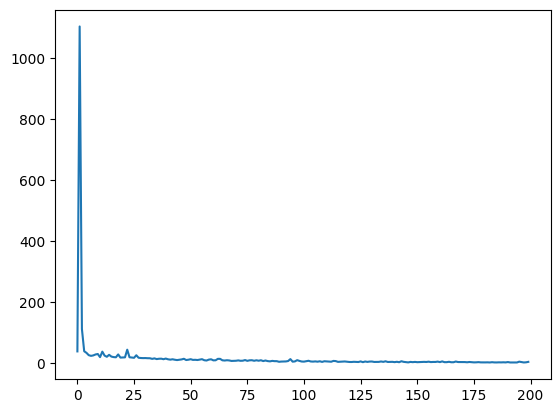

In [35]:
plt.plot(loss_list)

# Saving Models

In [121]:
torch.save(detector.state_dict(), "/content/drive/MyDrive/IntelAiHackathon/model.pt")

In [122]:
torch.save(detector, "/content/drive/MyDrive/IntelAiHackathon/model_detection.pt")

# Inference

In [36]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)
print("*****************")
print("proposals:", proposals_final)
print("confidence score:", conf_scores_final)
print("classes", classes_final)

*****************
proposals: [tensor([[ 9.4754,  3.1509, 17.5295,  8.5196],
        [ 1.4986,  7.0218,  7.5403, 10.2002]]), tensor([[ 2.1647,  3.3758, 19.5078, 12.2389],
        [-0.2027, -4.3145,  3.6201,  1.8458]])]
confidence score: [tensor([0.9998, 0.9942]), tensor([0.9999, 0.9975])]
classes [tensor([0, 0]), tensor([1, 0])]


In [37]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
print(prop_proj_1)
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')
print(prop_proj_2)

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
print(classes_pred_1)
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]
print(classes_pred_2)

tensor([[303.2114, 100.8283, 560.9428, 272.6259],
        [ 47.9565, 224.6965, 241.2894, 326.4072]])
tensor([[  69.2710,  108.0240,  624.2495,  391.6460],
        [  -6.4869, -138.0645,  115.8432,   59.0654]])
['ON_Laptop', 'ON_Laptop']
['OFF_Laptop', 'ON_Laptop']


In [38]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

# Counting Number of ON and OFF Appliances

In [40]:
# Define the name of classes
class_names = ["ON_Laptop", "OFF_Laptop"]

# Convert predicted classes to a list of class labels
pred_classes = [idx2name[cls.item()] for cls_list in classes_final for cls in cls_list]

# Convert ground truth classes to a list of class labels
gt_classes = [idx2name[cls.item()] for cls_list in gt_classes_batch for cls in cls_list]

In [41]:
# Count the number of detected ON_Laptop and OFF_Laptop instances
num_on_laptop = pred_classes.count("ON_Laptop")
num_off_laptop = pred_classes.count("OFF_Laptop")

print("Number of detected ON_Laptop instances:", num_on_laptop)
print("Number of detected OFF_Laptop instances:", num_off_laptop)

Number of detected ON_Laptop instances: 3
Number of detected OFF_Laptop instances: 1


# Power Consumption

In [43]:
# Define the power consumption of a laptop in watts
power_per_laptop = 75  # watts

# Calculate the total power used by ON laptops
total_power_used = num_on_laptop * power_per_laptop

print("Total power used by ON laptops:", total_power_used, "watts")

Total power used by ON laptops: 225 watts


In [44]:
# Define the power consumption of each electrical appliance in watts
power_labels = {
    "Laptop": 75,  # watts
    "ceiling fan": 50,     # watts
    "Light": 25,   # watts
    "AirConditioner" : 3000,
    "Human" : 115
    # Add more appliances and their power consumption here
}

# Create a dictionary to store the detected instances
detected_instances = {}

# Combine the predicted classes and their counts into the detected_instances dictionary
for cls in pred_classes:
    detected_instances[cls] = detected_instances.get(cls, 0) + 1

# Print the detected instances
print("Detected instances:", detected_instances)

# Initialize total power used
total_power_used = 0

# Iterate over the detected instances
for appliance, count in detected_instances.items():
    # Check if the appliance is ON
    if appliance.startswith("ON_"):
        # Get the power consumption of the appliance
        power_consumption = power_labels.get(appliance[3:], 0)  # Remove "ON_" prefix
        # Calculate the power used by multiplying the count with power consumption
        total_power_used += count * power_consumption

print("Total power used by ON appliances:", total_power_used, "watts")


Detected instances: {'ON_Laptop': 3, 'OFF_Laptop': 1}
Total power used by ON appliances: 225 watts


# Getting Bounding Box Coordinate

In [45]:
# Iterate over each proposal to extract bounding box coordinates
for i, proposal_tensor in enumerate(proposals_final):
    # Extract the list of bounding box coordinates from the tensor
    proposal = proposal_tensor.tolist()[0]
    # Unpack the bounding box coordinates
    x_min, y_min, x_max, y_max = proposal
    # Print the bounding box coordinates
    print(f"Bounding box {i+1} coordinates: (x_min={x_min}, y_min={y_min}), (x_max={x_max}, y_max={y_max})")


Bounding box 1 coordinates: (x_min=9.47535514831543, y_min=3.1508848667144775), (x_max=17.529462814331055, y_max=8.519560813903809)
Bounding box 2 coordinates: (x_min=2.164719581604004, y_min=3.3757505416870117), (x_max=19.507797241210938, y_max=12.238938331604004)


In [47]:
import math

# Function to calculate the centroid of a bounding box
def calculate_centroid(bbox):
    x_min, y_min, x_max, y_max = bbox
    return ((x_min + x_max) / 2, (y_min + y_max) / 2)

# Function to calculate the Euclidean distance between two points
def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Create lists to store predicted classes and bounding box coordinates for ON appliances
on_appliance_classes = []
on_appliance_bboxes = []

# Iterate over each proposal to extract bounding box coordinates
for i, proposal_tensor in enumerate(proposals_final):
    # Extract the list of bounding box coordinates from the tensor
    proposal = proposal_tensor.tolist()[0]
    # Unpack the bounding box coordinates
    x_min, y_min, x_max, y_max = proposal
    # Get the corresponding class predictions for this proposal
    class_predictions = classes_final[i].tolist()
    # Convert class prediction indices to class names
    class_names = [idx2name[class_pred] for class_pred in class_predictions]
    # Iterate over class names
    for class_name in class_names:
        # Check if the class name starts with "ON_"
        if class_name.startswith("ON_"):
            # Print the bounding box coordinates for ON appliance
            print(f"Bounding box {i+1} coordinates for {class_name}: (x_min={x_min}, y_min={y_min}), (x_max={x_max}, y_max={y_max})")
            # Append class name and bounding box coordinates to the lists
            on_appliance_classes.append(class_name)
            on_appliance_bboxes.append((x_min, y_min, x_max, y_max))

# Iterate over ON appliance instances to calculate distances to OFF_Laptop instances
for i, on_appliance_bbox in enumerate(on_appliance_bboxes):
    on_appliance_centroid = calculate_centroid(on_appliance_bbox)
    print(f"{on_appliance_classes[i]} centroid:", on_appliance_centroid)

    # Iterate over other classes to find OFF_Laptop instances
    for j, proposal_tensor in enumerate(proposals_final):
        class_predictions = classes_final[j].tolist()
        class_names = [idx2name[class_pred] for class_pred in class_predictions]

        if "OFF_Laptop" in class_names:
            off_laptop_bbox = proposal_tensor.tolist()[0]
            off_laptop_centroid = calculate_centroid(off_laptop_bbox)
            distance = calculate_distance(on_appliance_centroid, off_laptop_centroid)
            print(f"Distance between {on_appliance_classes[i]} and people: {distance}")



Bounding box 1 coordinates for ON_Laptop: (x_min=9.47535514831543, y_min=3.1508848667144775), (x_max=17.529462814331055, y_max=8.519560813903809)
Bounding box 1 coordinates for ON_Laptop: (x_min=9.47535514831543, y_min=3.1508848667144775), (x_max=17.529462814331055, y_max=8.519560813903809)
Bounding box 2 coordinates for ON_Laptop: (x_min=2.164719581604004, y_min=3.3757505416870117), (x_max=19.507797241210938, y_max=12.238938331604004)
ON_Laptop centroid: (13.502408981323242, 5.835222840309143)
Distance between ON_Laptop and people: 3.3162663421683254
ON_Laptop centroid: (13.502408981323242, 5.835222840309143)
Distance between ON_Laptop and people: 3.3162663421683254
ON_Laptop centroid: (10.83625841140747, 7.807344436645508)
Distance between ON_Laptop and people: 0.0


# Recommendation

In [49]:
# Set threshold distance
threshold_distance = 2.0  # Adjust as needed

# Iterate over ON appliance instances to calculate distances to OFF_Laptop instances
for i, on_appliance_bbox in enumerate(on_appliance_bboxes):
    on_appliance_centroid = calculate_centroid(on_appliance_bbox)
    print(f"{on_appliance_classes[i]} centroid:", on_appliance_centroid)

    # Iterate over other classes to find OFF_Laptop instances
    for j, proposal_tensor in enumerate(proposals_final):
        class_predictions = classes_final[j].tolist()
        class_names = [idx2name[class_pred] for class_pred in class_predictions]

        if "OFF_Laptop" in class_names:
            off_laptop_bbox = proposal_tensor.tolist()[0]
            off_laptop_centroid = calculate_centroid(off_laptop_bbox)
            distance = calculate_distance(on_appliance_centroid, off_laptop_centroid)
            print(f"Distance between {on_appliance_classes[i]} and OFF_Laptop: {distance}")

            # Make recommendation based on distance
            if distance > threshold_distance:
                print(f"Recommendation: Turn OFF {on_appliance_classes[i]} due to proximity to OFF_Laptop.")


ON_Laptop centroid: (13.502408981323242, 5.835222840309143)
Distance between ON_Laptop and OFF_Laptop: 3.3162663421683254
Recommendation: Turn OFF ON_Laptop due to proximity to OFF_Laptop.
ON_Laptop centroid: (13.502408981323242, 5.835222840309143)
Distance between ON_Laptop and OFF_Laptop: 3.3162663421683254
Recommendation: Turn OFF ON_Laptop due to proximity to OFF_Laptop.
ON_Laptop centroid: (10.83625841140747, 7.807344436645508)
Distance between ON_Laptop and OFF_Laptop: 0.0


# Real time Inference Testing

In [50]:
import cv2
import torch
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils import *

# Load the pre-trained Faster R-CNN model
# model = fasterrcnn_resnet50_fpn(pretrained=True)
# model.eval()

# Load the trained model weights
model_detection = torch.load("/content/drive/MyDrive/IntelAiHackathon/model_detection.pt")
model_detection.eval()

# Initialize the webcam
cap = cv2.VideoCapture(0)
print("-----------------------------------------------")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL Image
        transforms.Resize((img_height, img_width)),  # Resize the image
        transforms.ToTensor(),  # Convert PIL Image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Preprocess the frame
    input_image = transform(frame)
    input_image = input_image.unsqueeze(0)  # Add batch dimension

    # Perform object detection
    with torch.no_grad():
        predictions = model(input_image)

    # Display the results
    for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        box = [int(coord) for coord in box]
        frame = cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        frame = cv2.putText(frame, f'{label}: {score}', (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the frame
    cv2.imshow('Object Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


-----------------------------------------------
